##Getting dataset from Kaggle
- Using kaggle's API to get the dataset
- Then downloaded the dataset and saved in my google drive

In [ ]:
from google.colab import files
files.upload()

from google.colab import drive
drive.mount('/content/drive')

Saving kaggle.json to kaggle.json
Mounted at /content/drive


In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 65 Dec 16 05:16 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          17925  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          10662  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5315  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3833  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [ ]:
! kaggle datasets download "uldisvalainis/audio-emotions"

 99% 1.11G/1.12G [00:29<00:00, 34.1MB/s]
100% 1.12G/1.12G [00:29<00:00, 40.8MB/s]


In [ ]:
# ! unzip '/content/drive/MyDrive/final_project_328/audio-emotions.zip' -d '/content/drive/MyDrive/final_project_328'

In [ ]:
! unzip '/content/audio-emotions.zip'

##Model

In [2]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
from tqdm import tqdm

**Loading Data**

In [3]:
file_path = r'/content/drive/MyDrive/final_project_328/Emotions'
# path_directory = '/content/drive/MyDrive/final_project_328'
categories = os.listdir(file_path)

path = []
# target emotions
labels = []
cnt = 0

for category in categories:
 
  # goes into each individual folder.
  
  if category == 'Happy' or category == 'Sad':
    print(category)
    folder = os.path.join(file_path, category)
    for image in os.listdir(folder):
      audio_link = os.path.join(folder, image)
      path.append(audio_link)
      labels.append(category)

print('---------Data Loaded--------')

Happy
Sad
---------Data Loaded--------


In [4]:
# Checking the label count distribution 
data = pd.DataFrame(labels, columns = ['labels'])
data = pd.concat([data, pd.DataFrame(path, columns = ['path'])], axis = 1)

print(data)
print('\n')
print(data.labels.value_counts())

     labels                                               path
0     Happy  /content/drive/MyDrive/final_project_328/Emoti...
1     Happy  /content/drive/MyDrive/final_project_328/Emoti...
2     Happy  /content/drive/MyDrive/final_project_328/Emoti...
3     Happy  /content/drive/MyDrive/final_project_328/Emoti...
4     Happy  /content/drive/MyDrive/final_project_328/Emoti...
...     ...                                                ...
4329    Sad  /content/drive/MyDrive/final_project_328/Emoti...
4330    Sad  /content/drive/MyDrive/final_project_328/Emoti...
4331    Sad  /content/drive/MyDrive/final_project_328/Emoti...
4332    Sad  /content/drive/MyDrive/final_project_328/Emoti...
4333    Sad  /content/drive/MyDrive/final_project_328/Emoti...

[4334 rows x 2 columns]


Sad      2167
Happy    2167
Name: labels, dtype: int64


**Visualizing *Happy* waveform**

Happy - Emotion
/content/drive/MyDrive/final_project_328/Emotions/Happy/03-02-03-01-02-02-03.wav


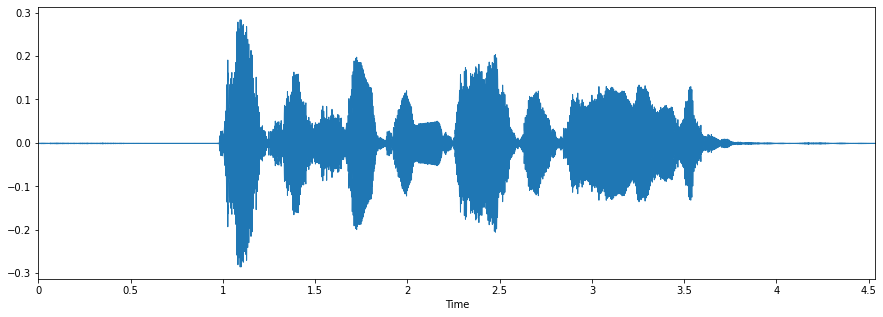

In [5]:
print('Happy - Emotion')
print(path[1110])
file_name = path[1110]
d, sampling_rate = librosa.load(file_name)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(d, sr=sampling_rate)

**Visualizing *Sad* waveform**

Sad - Emotion
/content/drive/MyDrive/final_project_328/Emotions/Sad/1061_ITH_SAD_XX.wav


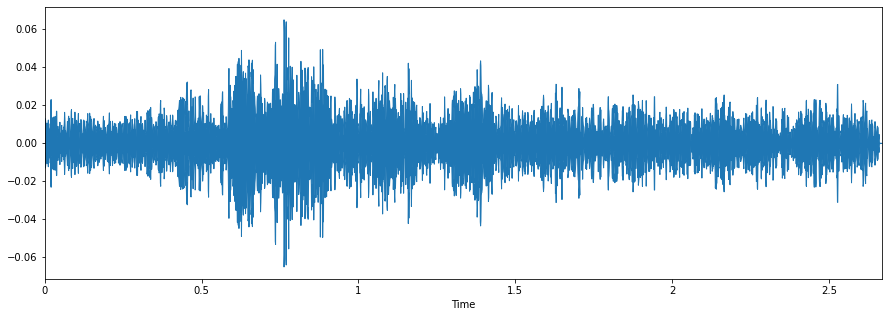

In [6]:
print('Sad - Emotion')
print(path[2190])
file_name = path[2190]
d, sampling_rate = librosa.load(file_name)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(d, sr=sampling_rate)

**Extract feature - MFCC**

In [ ]:
def extract_features(data, feature_type):
    features_df = pd.DataFrame(columns=['feature'])

    # loop feature extraction over the entire dataset
    counter = 0
    for index, path in tqdm(enumerate(data.path)):
        X, sample_rate = librosa.load(path, res_type='kaiser_fast'
                                      ,duration=2.5
                                      ,sr=44100
                                      ,offset=0.5
                                    )
        sample_rate = np.array(sample_rate)
        # mean as the feature.
        if feature_type == 'mean':
            mfccs_mean = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
            
        # max as the feature.
        elif feature_type == 'max':
            mfccs_max = np.max(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        
        # mean + max as the feature
        elif feature_type == 'both':
            mfccs_mean = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
            mfccs_max = np.max(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    
        features_df.loc[counter] = [mfccs_max]
        counter += 1

    return features_df

features_df = extract_features(data, feature_type='max')
data = pd.concat([data, pd.DataFrame(features_df['feature'].values.tolist())], axis=1)
data.to_csv("data_MFCC_max.csv")

3542it [12:55,  2.02it/s]

In [ ]:
# X : data for training
X = data[range(0, 216)]
X = X.fillna(0)
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215
0,122.175385,124.251907,121.603775,116.264420,117.974869,134.804504,155.419128,158.104416,175.102127,185.665436,184.162354,173.702209,166.781326,166.409821,178.671356,181.370728,180.360382,182.692810,177.466156,182.854614,176.440338,174.276093,178.889450,183.174561,177.218979,172.903259,165.107437,152.639221,137.536560,125.550522,118.031433,111.288483,110.863495,107.721405,101.595337,106.969818,112.315048,108.898178,121.027939,133.968842,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,204.942169,229.332581,242.531143,243.484482,243.043869,240.104858,242.089355,236.631683,221.613068,214.850647,211.599274,198.877350,187.119019,181.397842,171.515778,158.206390,150.249237,148.209961,140.978271,137.778870,133.836884,133.928665,140.710846,159.768600,181.024063,189.500793,193.206207,198.568954,201.866852,202.296417,198.191330,189.382919,183.826355,189.073273,186.355774,178.755463,169.447815,169.100555,180.761612,206.059158,...,117.260460,114.463089,117.348221,117.298080,112.174530,109.975494,111.553101,116.734711,123.045334,118.424789,109.632011,110.350044,109.494484,112.654602,118.792480,119.519730,110.939293,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,158.355453,158.441986,151.634232,143.124878,136.095215,126.754181,121.390030,110.223404,95.989029,91.495461,96.425232,110.416519,140.143906,166.715546,179.144852,182.368835,182.765320,178.186249,174.806808,173.929321,179.672974,186.218155,195.917664,209.303284,224.489944,225.725586,228.363434,233.946457,242.759033,252.019592,254.160004,255.633270,247.090271,242.369293,233.156982,227.358139,225.916428,228.777267,227.490295,226.454376,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,213.909668,210.275742,188.381592,178.521027,173.389633,165.894669,156.198700,153.033295,154.239746,161.506500,180.697052,192.984573,195.299286,191.506714,192.813370,189.694778,186.487305,192.759735,208.658264,208.147797,201.449493,196.654297,191.978943,186.925705,180.178406,169.303986,161.810760,164.924103,168.268173,173.244720,173.279297,170.627182,170.037704,177.809265,181.879059,187.506409,188.126419,183.770477,180.703796,186.785126,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,194.295303,205.173615,206.944107,209.941071,211.874237,213.925629,213.771881,209.039459,199.646057,187.293854,170.827759,158.824402,138.393372,144.366501,164.732239,175.585907,193.454132,216.508026,221.614685,217.319855,212.947937,210.455002,205.171066,191.793671,186.479370,190.923447,194.861130,189.788635,179.736038,173.834595,180.159576,191.042542,195.431183,192.457275,188.641571,183.916718,175.664917,167.976761,161.119293,162.374146,...,0.000000,0.000000,0.0000

In [ ]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers

**Splitting dataset into train and test**

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(X, data.labels.to_numpy(), test_size=0.25, shuffle=True, random_state=42)

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)



label_enc = LabelEncoder()
y_train = label_enc.fit_transform(y_train)
y_test = label_enc.fit_transform(y_test)

y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

print(label_enc.classes_)

['Happy' 'Sad']


**Building model**

In [ ]:
# New model
def model_one():
    model = Sequential()
    model.add(Conv1D(256, 8, activation='relu', padding='same', input_shape=(X_train.shape[1],1)))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(128, 8, activation='relu', padding='same'))
    model.add(Dropout(0.25))
    model.add(MaxPooling1D(pool_size=(8)))
    model.add(Conv1D(64, 8, activation='relu', padding='same'))
    model.add(Flatten())
    model.add(Dropout(0.25))
    # 50 neurons flatten layers
    model.add(Dense(50, activation='relu'))
    # target layer with 2 outcomes - 'Happy', 'Sad'
    model.add(Dense(2,  activation='softmax')) 
    return model


X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print('X train shape : ', X_train.shape)
print('X test shape : ', X_test.shape)

model = model_one()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mh = model.fit(X_train, y_train, batch_size=16, epochs=35, validation_data=(X_test, y_test))

X train shape :  (3250, 216, 1)
X test shape :  (1084, 216, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          2304      
                                                                 
 dropout (Dropout)           (None, 216, 256)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 27, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 27, 128)           262272    
                                                                 
 dropout_1 (Dropout)         (None, 27, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 128)           0   

**Plotting the loss**

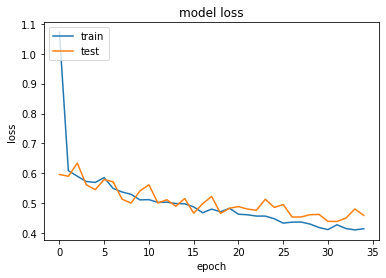

In [ ]:
plt.plot(mh.history['loss'])
plt.plot(mh.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Save the Model**

In [ ]:
model_name = 'Model_mfcc_max.h5'
save_dir = os.path.join('/content/drive/MyDrive/final_project_328', 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

model_json = model.to_json()
with open("model_json.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /content/drive/MyDrive/final_project_328/saved_models/Model_mfcc_max.h5 
